# Logistic Regression on CTR data
This notebook details getting click-through-rate predicitions using part of the Criteo dataset from this [Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge).

The notebook is based upon a lab I did for the [Berkeley edX CS190.1x, Scalable Machine Learning](https://www.edx.org/course/scalable-machine-learning-uc-berkeleyx-cs190-1x) class.  Instead of using PySpark as we did in the class, I'll use pandas and scikit-learn for a local, one node workflow.

## Obtaining the data from Criteo

We need to get the data to work with from Criteo.  Here I'm using a script very similar to the one from the edX class.  After running the next cell, I accept the agreement and get the url for the sample by right clicking on 'download sample'.  I then paste this url into the download script.

In [1]:
# setup plotting
%matplotlib inline

# Run this code to view Criteo's agreement
from IPython.lib.display import IFrame

IFrame("http://labs.criteo.com/downloads/2014-kaggle-display-advertising-challenge-dataset/",
       600, 350)

In [2]:
# script from edX 190 class, with directory modifications
import glob
import os.path
import tarfile
import urllib
import urlparse

# Paste url, url should end with: dac_sample.tar.gz
url = 'http://labs.criteo.com/wp-content/uploads/2015/04/dac_sample.tar.gz'

url = url.strip()
fileName = os.path.join('dac_sample.txt')

def extractTar(check = False):
    # Find the zipped archive and extract the dataset
    tars = glob.glob('dac_sample*.tar.gz*')
    if check and len(tars) == 0:
      return False

    if len(tars) > 0:
        try:
            tarFile = tarfile.open(tars[0])
        except tarfile.ReadError:
            if not check:
                print 'Unable to open tar.gz file.  Check your URL.'
            return False

        tarFile.extract('dac_sample.txt')
        print 'Successfully extracted: dac_sample.txt'
        return True
    else:
        print 'You need to retry the download with the correct url.'
        print ('Alternatively, you can upload the dac_sample.tar.gz file to your Jupyter root ' +
              'directory')
        return False


if os.path.isfile(fileName):
    print 'File is already available. Nothing to do.'
elif extractTar(check = True):
    print 'tar.gz file was already available.'
elif not url.endswith('dac_sample.tar.gz'):
    print 'Check your download url.  Are you downloading the Sample dataset?'
else:
    # Download the file and store it in the same directory as this notebook
    try:
        urllib.urlretrieve(url, os.path.basename(urlparse.urlsplit(url).path))
    except IOError:
        print 'Unable to download and store: {0}'.format(url)

    extractTar()

Successfully extracted: dac_sample.txt


## Load data into pandas

This is where we diverge from the edX class.  Instead of loading the data into a Spark Resilient Distributed Dataset (RDD), we load it into a pandas DataFrame.  The next cell shows the first 2 lines of the data.  As you can see, it's tab delimited, with the label as the first entry in each line.

The cell after next puts the data into a DataFrame.  From there we use scikit-learn to split the data into train, cross-validation, and test sets. **Note:** We need to use numpy arrays for sklearn so we extract these from the DataFrame using the `.values` attribute.  Also, note that I had lots of problems with  `NaN`s generated when loading the data into pandas, so I set  `na_filter = False` and just deal with the empty strings this generates later in the code.

In [3]:
# Show the first 2 lines of the data
with open(fileName) as f:
    for i in xrange(2):
        line = f.readline()
        print line

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16

0	2	0	44	1	102	8	2	2	4	1	1		4	68fd1e64	f0cf0024	6f67f7e5	41274cd7	25c83c98	fe6b92e5	922afcc0	0b153874	a73ee510	2b53e5fb	4f1b46f3	623049e6	d7020589	b28479f6	e6c5b5cd	c92f3b61	07c540c4	b04e4670	21ddcdc9	5840adea	60f6221e		3a171ecb	43f13e8b	e8b83407	731c3655



In [4]:
import pandas as pd
import numpy as np
print 'pandas version ' + pd.version.version
from sklearn import cross_validation

raw_data_df = pd.read_csv(fileName, sep='\t', header=None, na_filter=False)

train_data, eval_data = cross_validation.train_test_split(raw_data_df.values,
                                                          test_size=0.2,
                                                          random_state=42)
cv_data, test_data = cross_validation.train_test_split(eval_data,
                                                       test_size=0.5,
                                                       random_state=42)
print train_data.shape, cv_data.shape, test_data.shape

# Using nomenclature of sklearn, we separate the data into a label vector, y_
# and an observation matrix, X_
# make sure the elements in y are defined as floats as required by the classifier
y_train = np.asarray(train_data[:,0], dtype=np.float)
X_train = train_data[:,1:]
y_cv = np.asarray(cv_data[:,0], dtype=np.float)
X_cv = cv_data[:,1:]
y_test = np.asarray(test_data[:,0], dtype=np.float)
X_test = test_data[:,1:]
print y_train.shape, X_train.shape
print X_cv

pandas version 0.16.0
(80000, 40) (10000, 40) (10000, 40)
(80000,) (80000, 39)
[['5' -1 '' ..., '3b183c5c' '001f3601' 'e914c1e9']
 ['' 685 '' ..., '9228103e' '' '']
 ['0' 0 '7' ..., 'e1b26251' '9b3e8820' '11676e04']
 ..., 
 ['0' 397 '1' ..., 'b61e3676' '' '']
 ['2' 0 '26' ..., 'd61a7d0a' '9b3e8820' 'b29c74dc']
 ['20' -1 '1' ..., '6bdf991d' 'e8b83407' '61e54666']]


## One Hot Encoding (OHE)
Since the raw data contain some categorical values, I'll use OHE to transform the data points from Criteo into features that can be used in logistic regression.  To make this easier, I'll assume that all the features are categorical.  First I need to map the raw data from simply a categorical value for a given feature to a tuple of the form `(feature_id, categorical_value)`.  I can then use each of these tuples as the key in a dictionary (called the OHE dictionary) where the value is a unique integer.  It's important to make sure that each of the key tuples is unique as well otherwise I'll have *n* different values in my OHE dictionary for a distinct tuple that appears *n* times.  I should also do this only using the training data to not bias the model.

In [5]:
def create_OHE_dict(data):
    """Creates a OHE dictionary from 'data'.
    
    Args:
        data (pandas DataFrame of shape n observations by d feature_ids): DataFrame consisting of
            n rows of observations and d columns of categories.
            
    Returns:
        OHE_dict: a dictionary where the keys are (feature_id, category) tuples and map to values
            that are unique integers
    """
    OHE_dict = {}
    j = 0 
    # for loop iterates on df giving Series
    for c in data.columns:
        f_keys = data[c].map(lambda v: (c, v)).unique()
        for key in f_keys:
            OHE_dict[key] = j
            j += 1
    print 'There are {0} OHE features'.format(j)
    return OHE_dict

df_X_train = pd.DataFrame(X_train)
OHE_train_dict = create_OHE_dict(df_X_train)


There are 233397 OHE features


## Use the OHE dict to map the feature values to integers
Now, we have the OHE dictionary so we need to use it to encode each feature value in the training dataset with the appropriate integer from the OHE dict.  This should generate a dense matrix where each column is still the original raw feature column but the element in each column is now an integer from the OHE dict mapping.  We can then use the `OneHotEncoder` transformer from scikit-learn to transform the dense matrix into a sparse matrix for input into our logistic regression classifier.

### Methodology
As in the `create_OHE_dict` function, we iterate across the columns of the data set, represented in a pandas DataFrame, to form `(column, feature_value)` tuples that we then look up in the OHE dict and replace with the appropriate value from the OHE dict.

Since this technique will also be used for the cv and test datasets, it is important to make sure that we have a way to represent categories that are not in the training dataset but may be in the cv or test datasets.  Since `OneHotEncoder` requires all values to be positive integers, if an unseen category arises that is not in the OHE dict, I assign it a large integer using `OHE_lookup()` and instantiate `OneHotEncoder` with the `ignore` flag so that these unseen categories will be ignored during the dense to sparse transformation.

In [6]:
def OHE_lookup(OHE_dict, (feature_id, category)):
    """Checks if the given (feature_id, category) tuple is in the OHE and returns associated 
    value if it is or 999,999,999 if it isn't
    
    Args:
        OHE_dict (dict): keys are (feature_id, category) tuples and map to values
            that are unique integers
        (feature_id, category) (tuple of (int, str)):  the feature_id and associated category
        
    Returns:
        value: (int) either the value associated with the given (feature_id, category) or -1 if
            the key tuple is not in 'OHE_dict'
    """
    try:
        value = OHE_dict[(feature_id, category)]
    except KeyError:
        value = 999999999
    return value
    
def OHE_map(data, OHE_dict):
    """Maps feature values in 'data' to the appropriate OHE feature specified in the 'OHE_dict'.
    Creates a new DataFrame of the same size as 'data'.
    
    Args:
        data (pandas DataFrame of shape n observations by d feature_ids): DataFrame consisting
            of n rows of observations and d columns of categories.
        OHE_dict (dict): keys are (feature_id, category) tuples and map to values
            that are unique integers
            
    Returns:
        OHE_df (pandas DataFrame of same shape as 'data'): DataFrame that has mapped each 
            element of the DataFrame from the category to the appropriate integer specified
            in 'OHE_dict'
    """
    OHE_df = data.copy()
    # for loop iterates on df giving Series
    for c in OHE_df.columns:
        # use .loc[] instead of just indexing into the df
        # see http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
        # for rationale
        OHE_df.loc[:,c] = data.loc[:,c].map(lambda v: OHE_lookup(OHE_dict, (c, v)))
                                              
    return OHE_df

df_X_train_OHE = OHE_map(df_X_train, OHE_train_dict)
df_X_train_OHE
    

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0,142,2601,3455,3585,23923,25825,26405,26548,28356,...,178673,178683,181090,182319,182323,214204,214215,214229,225027,225078
1,1,143,2602,3456,3586,23923,25826,26406,26549,28357,...,178674,178684,181091,182319,182324,214204,214216,214230,225028,225079
2,2,142,2603,3457,3587,23924,25827,26407,26550,28358,...,178675,178685,181092,182320,182325,214205,214216,214231,225029,225080
3,1,144,2601,3458,3588,23925,25827,26408,26551,28357,...,178676,178686,181093,182319,182326,214204,214217,214232,225030,225081
4,3,143,2604,3459,3589,23926,25828,26409,26552,28356,...,178677,178687,181092,182320,182327,214204,214216,214233,225029,225080
5,1,145,2605,3456,3586,23927,25826,26408,26553,28357,...,178674,178688,181092,182320,182328,214206,214216,214234,225029,225080
6,4,146,2606,3458,3590,23928,25827,26410,26554,28356,...,178676,178689,181094,182321,182329,214204,214217,214235,225030,225082
7,1,142,2604,3458,3591,23929,25829,26411,26555,28357,...,178677,178690,181092,182320,182330,214205,214218,214236,225029,225080
8,1,147,2607,3456,3592,23930,25827,26406,26556,28357,...,178675,178691,181095,182319,182331,214204,214217,214237,225030,225083
9,2,148,2608,3460,3593,23931,25830,26412,26557,28358,...,178673,178692,181092,182320,182332,214204,214215,214238,225029,225080


In [7]:
from sklearn.preprocessing import OneHotEncoder

# ignore features that are not in the training data set
OHE_enc = OneHotEncoder(handle_unknown='ignore')
X_train_sparse = OHE_enc.fit_transform(df_X_train_OHE)
print type(X_train_sparse)
print X_train_sparse.shape
#print train_OHE_sparse.toarray()

<class 'scipy.sparse.csr.csr_matrix'>
(80000, 233397)


## Train Logistic Regression classifier
Here we use the `LogisticRegression` classifier from scikit-learn with default values and the 'lbfgs' solver and seed with 42 to make the result reproducible.  Later we'll optimize the ridge regularization hyperparameter, `C`.

In [9]:
# Note: when this cell is first run, a failure to converge warning is thrown
# Running it a second time does not give this warning
from sklearn.linear_model import LogisticRegression
lr0 = LogisticRegression(solver='lbfgs', random_state=42, verbose=1)
print lr0.get_params()
lr0.fit(X_train_sparse, y_train)
#y_pred = lr.predict(X_train_sparse)
#print y_train, y_pred

{'C': 1.0, 'verbose': 1, 'intercept_scaling': 1, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'multi_class': 'ovr', 'random_state': 42, 'dual': False, 'tol': 0.0001, 'solver': 'lbfgs', 'class_weight': None}


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=42, solver='lbfgs', tol=0.0001,
          verbose=1)

## Encode CV and test data sets using OHE
Now that we've converted our training data into a OHE sparse matrix and trained a logistic regression classifier on this data, it's time to evaluate our model using initially the CV dataset and later the test dataset that we reserved earlier.  To do that we need to convert these sets into sparse matrices as well.  As noted above, we may have feature values that we haven't observed in the training set in the CV and test sets, so we need to ignore these features values if we see them when we do the encoding.

In [10]:
def generate_sparse_matrix(X_data, OHE_enc, OHE_dict):
    """Converts input ndarray X_data matrix to sparse matrices using an already fit
    OneHotEncoder object.
    
    Args:
        X_data (ndarray): array of n rows of observations where each observation is of
            the form feature_id_1, feature_id_2, ... feature_id_i, ... feature_id_d
        OHE_enc (OneHotEncoder): a OneHotEncoder object that has already been trained using
            the training data
        OHE_dict (dict): keys are (feature_id, category) tuples and map to values
            that are unique integers
            
    Returns:
        X (scipy csr sparse matrix): sparse matrix representation of 'X_data encoded by OHE_enc.
            Note: features seen in 'X_data' that are not in the training set will be ignored

    """
    X_df = pd.DataFrame(X_data)
    X_df_OHE = OHE_map(X_df, OHE_dict)
    X = OHE_enc.transform(X_df_OHE)
    return X

X_cv_sparse = generate_sparse_matrix(X_cv, OHE_enc, OHE_train_dict)
X_test_sparse = generate_sparse_matrix(X_test, OHE_enc, OHE_train_dict)
print X_cv.shape
print X_test.shape

(10000, 39)
(10000, 39)


# Model Evaluation using Log Loss
## Baseline model
The baseline model is where we simply predict the same click probability regardless of the observation.  The natural prediction value is the mean of the observations.  I've set up the `T` matrix in a form that can be used for evaluating the log loss criterion discussed below.

In [11]:
def baseline_probabilities(y):
    """Generate baseline probabilites for a given set of binary labels by predicting the outcome
    to be the average probability of all observations regardless of observation.
    
    Args:
        y (ndarray of floats): 1 dimensional array of labels
        
    Returns:
        T_baseline (ndarray of floats): n_labels x 2_classes with the 1st column the 
            probability of y = 0 and the second column the probability of y = 1
    """

    y_m = np.mean(y)
    #print y_m
    baseline_array = np.asarray([1-y_m, y_m])
    # set up a matrix similar to what is returned by LogisticRegression.predict_proba()
    return np.tile(baseline_array, (len(y),1))
    
T_train_baseline = baseline_probabilities(y_train)
print T_train_baseline, T_train_baseline.shape

[[ 0.773875  0.226125]
 [ 0.773875  0.226125]
 [ 0.773875  0.226125]
 ..., 
 [ 0.773875  0.226125]
 [ 0.773875  0.226125]
 [ 0.773875  0.226125]] (80000, 2)


## Evaluation on train and CV datasets
Now we evaluate the logistic regression model on our training and cv datasets using log loss as the quality criterion.  To do this we use the `predic_proba()` method from the logistic regression model to get the probabilities of our prediction and then use `log_loss` from scikit-learn.  We then compare this to the log loss of the baseline model.

In [12]:
from sklearn.metrics import log_loss

# calculate a n x 2 matrix with the first column the probability of
# the observation being 0 and the second column the probability being 1
T_train_lr0 = lr0.predict_proba(X_train_sparse)
T_cv_lr0 = lr0.predict_proba(X_cv_sparse)
T_cv_baseline = baseline_probabilities(y_cv)
# to see what the matrix looks like:
print T_cv_lr0
print T_cv_lr0.sum(axis=1)

train_loss_baseline = log_loss(y_train, T_train_baseline)
train_loss_lr0 = log_loss(y_train, T_train_lr0)
cv_loss_baseline = log_loss(y_cv, T_cv_baseline)
cv_loss_lr0 = log_loss(y_cv, T_cv_lr0)

print "\nOHE features training set log loss"
print "\tBaseline log loss: {0}".format(train_loss_baseline)
print "\tlr0 log loss: {0}".format(train_loss_lr0)
print "\nOHE features cv set log loss"
print "\tBaseline log loss: {0}".format(cv_loss_baseline)
print "\tlr0 log loss: {0}".format(cv_loss_lr0)

[[ 0.24290296  0.75709704]
 [ 0.07975715  0.92024285]
 [ 0.45474398  0.54525602]
 ..., 
 [ 0.57950176  0.42049824]
 [ 0.91964609  0.08035391]
 [ 0.87766565  0.12233435]]
[ 1.  1.  1. ...,  1.  1.  1.]

OHE features training set log loss
	Baseline log loss: 0.534551573941
	lr0 log loss: 0.214653143292

OHE features cv set log loss
	Baseline log loss: 0.540000312465
	lr0 log loss: 0.504406005727


## Plotting the ROC curves
Now that we have evaluated the data from the training and cv sets and compared them to the baseline model, we'll plot the Receiver Operating Characteristic (ROC) curve.  The training set is plotted in light blue, the cv set is in green and the baseline model is the dashed line.  As you can see, the training set works quite well with the model (as expected since this was the data set used to generate the model) while the cv set is not as good, but still better than the baseline.

In [13]:
#plot setup script from edX 190.1 class
import matplotlib.pyplot as plt

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax


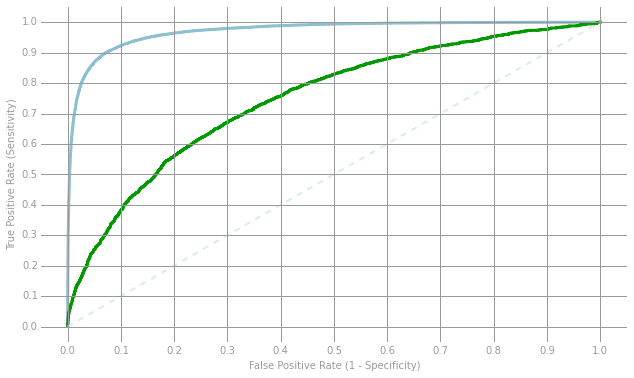

In [14]:
def ROC_params(y, T_matrix):
    """Generate true and false positive rates for plotting in a ROC curve using
    the labels and predicted probabilities from a dataset.
    
    Args:
        y (1D ndarray): the labels for a set of observations
        T_matrix(2D ndarray): the predicted probabilities for a set of observations where
            the 1st column is probability for y=0 and the 2nd column the probability
            for y=1
            
    Returns:
        truePositiveRate (1D ndarray): the ascending, cumulative rate of true positive values
            from the labeled data
        falsePositiveRate (1D ndarray): the ascending, cumulative rate of false positive
            values generated by the model
    """
    
    y_and_prob = np.column_stack((y, T_matrix[:,1]))
    # sort and retain y values based on ascending probability 
    labels_by_prob = y_and_prob[y_and_prob[:,1].argsort()[::-1]][:,0]
    
    length = len(labels_by_prob)
    truePositives = labels_by_prob.cumsum()
    numPositive = truePositives[-1]
    falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

    truePositiveRate = truePositives / numPositive
    falsePositiveRate = falsePositives / (length - numPositive)
    
    return truePositiveRate, falsePositiveRate

train_true_pr, train_false_pr = ROC_params(y_train, T_train_lr0)
cv_true_pr, cv_false_pr = ROC_params(y_cv, T_cv_lr0)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(train_false_pr, train_true_pr, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot(cv_false_pr, cv_true_pr, color='#009900', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
pass

## Tune model by optimizing regularization parameter, `C`
Now, to optimize `C`, we'll loop over selected values of `C` and train logistic regression models on the train set.  The quality of each model will be evaluated via the log loss on the cv set.  I'm choosing `C` to be logarithmically distributed between 1e-4 and 1e4 as suggested in the scikit-learn documentation

In [15]:
Cs = [10**i for i in xrange(-4,5)]
cv_loss_lr_best = cv_loss_baseline
for C in Cs:
    lr = LogisticRegression(solver='lbfgs', random_state=42, verbose=1, C=C)
    lr.fit(X_train_sparse, y_train)
    T_cv = lr.predict_proba(X_cv_sparse)
    cv_loss = log_loss(y_cv, T_cv)
    print "Log loss for C = {0} is {1}".format(C, cv_loss)
    if cv_loss < cv_loss_lr_best:
        cv_loss_lr_best = cv_loss
        lr_best = lr
        T_cv_best = T_cv
        print "Best lr model so far has C = {}\n".format(C)
        
    

Log loss for C = 0.0001 is 0.506291726589
Best lr model so far has C = 0.0001

Log loss for C = 0.001 is 0.471106473301
Best lr model so far has C = 0.001

Log loss for C = 0.01 is 0.449859021178
Best lr model so far has C = 0.01

Log loss for C = 0.1 is 0.444633985471
Best lr model so far has C = 0.1

Log loss for C = 1 is 0.504406005727
Log loss for C = 10 is 0.674588837249
Log loss for C = 100 is 0.933875417172
Log loss for C = 1000 is 0.829740247537
Log loss for C = 10000 is 0.8686252674


## ROC curve for lr0 and lr_best
Now we plot the ROC curve for the results from our initial model, `lr0`, where `C=1.0` (in green) and our best model, `lr_best`, where `C=0.1` (in red).

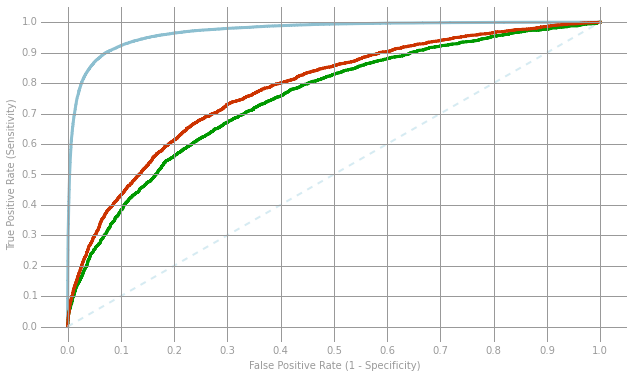

In [16]:
cv_true_pr_best, cv_false_pr_best = ROC_params(y_cv, T_cv_best)
# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(train_false_pr, train_true_pr, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot(cv_false_pr, cv_true_pr, color='#009900', linestyle='-', linewidth=3.)
plt.plot(cv_false_pr_best, cv_true_pr_best, color='#cc3300', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
pass

# Calculate log loss on test dataset using best logistic regression model
Now we finally evaluate our best model on our test dataset

In [17]:
T_test_baseline = baseline_probabilities(y_test)
T_test_lr_best = lr_best.predict_proba(X_test_sparse)
test_loss_baseline = log_loss(y_test, T_test_baseline)
test_loss_lr_best = log_loss(y_test, T_test_lr_best)

print "OHE features test set log loss"
print "\tBaseline log loss: {0}".format(test_loss_baseline)
print "\tlr_best log loss: {0}".format(test_loss_lr_best)

print "\nFor comparison, the cv log loss with lr_best:"
print "\t{}".format(cv_loss_lr_best)

OHE features test set log loss
	Baseline log loss: 0.535258065214
	lr_best log loss: 0.436820095401

For comparison, the cv log loss with lr_best:
	0.444633985471


## Comparison with results from PySpark in edX 190.1
Although the dataset splits and the logistic regression algorithms are different between the treatment presented here and that performed in edX 190.1, we see that the resulting baseline and test dataset log loss values are similar:

### PySpark with Feature Hashing (edX 190.1)
Baseline Log Loss on Test dataset:  0.537

LR_best Log Loss on Test dataset:  0.456

### Pandas and scikit-learn with OHE (this work)
Baseline Log Loss on Test dataset:  0.535

LR_best Log Loss on Test dataset:  0.437